<a href="https://colab.research.google.com/github/Humboldt-Penguin/Asteroid-Spectra-Classification-with-Machine-Learning/blob/main/Asteroid_Spectra_Classification_with_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Background

Asteroids appear like dots in a telescope. If they approach our planet quite close one can use radars to determine their size and shape quite well. The rest of the time scientists can "only" determine their brightness, indirectly their size, and orbit around the Sun (and other intrinsic parameters). That's it!

\

But one can also determine the spectrum of an asteroid: E.g., by determining the reflectance of the surface for different wavelengths. These reflectance spectra allow scientists to determine the composition of the object. In total, there are 4 "main groups":

1. C: Carbonaceous Asteroid, most common in the Solar System with... well you guess it, carbon-like compositions

2. S: ... like "stony" asteroids, silicates, minerals, etc. dominate the surface

3. X: -class asteroids are mostly classified as "iron" asteroids (no these are not pure "iron rocks" but show a high abundance of iron, nickel, etc.

4. Other: Outliers with rare or unique compositions

\

These main groups are the most common ones. Other classification systems by Bus et al., Tholen et al. and so on introduce more classes and differentiate them to up to 20 classes and more.

## Motivation: 

Bus et al. classified over 1200 spectra by hand (20 years ago), so we test Machine Learning algorithms on these data for classification purposes. This project includes fetching and parsing the data, to trainings of multi class Support Vector Machines (SVMs) using scikit-learn. Later, we can programm a small Feed-Forward and 1D Convolutional Neural Network using Keras to compress the spectra to a 2-dimensional space, to see whether "spectra clusters" appear that can be associated with these arbitrary classification schemas. 


## Abstract:
This data science and machine learning project is about classifying asteroid taxonomy spectra. We use over 1,000 spectra from [1] to train miscellaneous models to e.g., distinguish between the X class and non X class; to perform multi-label classification and unsupervised clustering using autoencoders.

---
# 1. Fetch Data

This section downloads all required asteroid taxonomy data. The data are from [1] and the corresponding classification schema has been defined by [2]. Further, the downloaded files are extracted.

In [1]:
import hashlib
import os
import pathlib
import tarfile
import urllib.request

In [2]:
# Mount  Google Drive for file/model storage
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Mounted at /gdrive


In [3]:
# Define function to compute the sha256 value of the downloaded files
def comp_sha256(file_name):
    """
    Compute the SHA256 hash of a file.
    Parameters
    ----------
    file_name : str
        Absolute or relative pathname of the file that shall be parsed.
    Returns
    -------
    sha256_res : str
        Resulting SHA256 hash.
    """
    # Set the SHA256 hashing
    hash_sha256 = hashlib.sha256()

    # Open the file in binary mode (read-only) and parse it in 65,536 byte chunks (in case of
    # large files, the loading will not exceed the usable RAM)
    with pathlib.Path(file_name).open(mode="rb") as f_temp:
        for _seq in iter(lambda: f_temp.read(65536), b""):
            hash_sha256.update(_seq)

    # Digest the SHA256 result
    sha256_res = hash_sha256.hexdigest()

    return sha256_res

In [4]:
# Create the level0 data directory
pathlib.Path(os.path.join(core_path, "data/lvl0/")).mkdir(parents=True, exist_ok=True)

In [5]:
# Set a dictionary that contains the taxonomy classification data and corresponding sha256 values
files_to_dl = \
    {'file1': {'url': 'http://smass.mit.edu/data/smass/Bus.Taxonomy.txt',
               'sha256': '0ce970a6972dd7c49d512848b9736d00b621c9d6395a035bd1b4f3780d4b56c6'},
     'file2': {'url': 'http://smass.mit.edu/data/smass/smass2data.tar.gz',
               'sha256': 'dacf575eb1403c08bdfbffcd5dbfe12503a588e09b04ed19cc4572584a57fa97'}}

In [6]:
# Iterate through the dictionary and download the files
for dl_key in files_to_dl:

    # Get the URL and create a download filepath by splitting it at the last "/"
    split = urllib.parse.urlsplit(files_to_dl[dl_key]["url"])
    filename = pathlib.Path(os.path.join(core_path, "data/lvl0/", split.path.split("/")[-1]))

    # Download file if it is not available
    if not filename.is_file():

        print(f"Downloading now: {files_to_dl[dl_key]['url']}")

        # Download file and retrieve the created filepath
        downl_file_path, _ = urllib.request.urlretrieve(url=files_to_dl[dl_key]["url"],
                                                        filename=filename)

        # Compute and compare the hash value
        TAX_HASH = comp_sha256(downl_file_path)
        assert TAX_HASH == files_to_dl[dl_key]["sha256"]

In [7]:
# Untar the spectra data
tar = tarfile.open(os.path.join(core_path, "data/lvl0/", "smass2data.tar.gz"), "r:gz")
tar.extractall(os.path.join(core_path, "data/lvl0/"))
tar.close()

---
# 2. Parse Data

This section takes now the downloaded files, parses and cleans the data and merges the taxonomy classification with the spectra data. The final dataset is stored in a Level 1 directory for further computations. Further, a first clean up is performed.

## 2.1. Setup

In [8]:
# Import standard libraries
import glob
import os
import pathlib
import re

# Import installed libraries
import pandas as pd

In [9]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [10]:
# Get a sorted list of all spectra files (consider only the spfit files that have been explained in
# the references)
spectra_filepaths = sorted(glob.glob(os.path.join(core_path, "data/lvl0/", "smass2/*spfit*")))

## 2.2. Asteroid Designation Separation
The spectra data have 2 different naming conventions starting with an "a" and starting with an "au". The first case corresponds to asteroids with an actual designation number (like (1) Ceres). The second case contains only temporary (at the time of the data release) designations (like 1995 BM2). Later, these spectra data need to be joined with the taxonomy class file



In [11]:
# Separate the filepaths into designation and non-designation files
des_file_paths = spectra_filepaths[:-8]
non_file_paths = spectra_filepaths[-8:]

# Convert the arrays to dataframes
des_file_paths_df = pd.DataFrame(des_file_paths, columns=["FilePath"])
non_file_paths_df = pd.DataFrame(non_file_paths, columns=["FilePath"])

In [12]:
# Add now the designation / "non"-designation number
des_file_paths_df.loc[:, "DesNr"] = des_file_paths_df["FilePath"] \
                                        .apply(lambda x: int(re.search(r'smass2/a(.*).spfit',
                                                                       x).group(1)))
non_file_paths_df.loc[:, "DesNr"] = non_file_paths_df["FilePath"] \
                                        .apply(lambda x: re.search(r'smass2/au(.*).spfit',
                                                                   x).group(1))

## 2.3. Taxonomy Classification

Now we read the taxonomy classification file. Theoretically, the file has only 3 columns (asteroid name, Tholen & Bus Classification) with a rather large header. However, due to some formatting errors and the usage of white spaces as well as tabulator tabs, Pandas identifies 5 columns in total.

Since one cannot assign these "unknown" classes correctly to either Tholen nor Bus, the corresponding rows are deleted later.



In [13]:
# Read the classification file
asteroid_class_df = pd.read_csv(
                                os.path.join(core_path, "data/lvl0/", "Bus.Taxonomy.txt"),
                                skiprows=21,
                                sep="\t",
                                names=[
                                       "Name",
                                       "Tholen_Class",
                                       "Bus_Class",
                                       "unknown1",
                                       "unknown2"
                                      ]
                               )

# Remove white spaces
asteroid_class_df.loc[:, "Name"] = asteroid_class_df["Name"].apply(lambda x: x.strip()).copy()

# Separate between designated and non-designated asteroid classes
des_ast_class_df = asteroid_class_df[:1403].copy()
non_ast_class_df = asteroid_class_df[1403:].copy()

In [14]:
# Now split the designated names and get the designation number (to link with the spfit files)
des_ast_class_df.loc[:, "DesNr"] = des_ast_class_df["Name"].apply(lambda x: int(x.split(" ")[0]))

# Merge with the spectra file paths
des_ast_class_join_df = des_ast_class_df.merge(des_file_paths_df, on="DesNr")

# For the non designated names, one needs to remove the white space between number and name and
# compare with the file paths
non_ast_class_df.loc[:, "DesNr"] = non_ast_class_df["Name"].apply(lambda x: x.replace(" ", ""))

# Merge with the spectra file paths
non_ast_class_join_df = non_ast_class_df.merge(non_file_paths_df, on="DesNr")

In [15]:
# Merge now both datasets
asteroids_df = pd.concat([des_ast_class_join_df, non_ast_class_join_df], axis=0)

# Reset the index
asteroids_df.reset_index(drop=True, inplace=True)

# Remove the tholen class and both unknown columns
asteroids_df.drop(columns=["Tholen_Class", "unknown1", "unknown2"], inplace=True)

# Drop now all rows that do not contains a Bus Class
asteroids_df.dropna(subset=["Bus_Class"], inplace=True)

## 2.4. Read and store the Spectra into a Dataframe

In [16]:
# Read and store the spectra
asteroids_df.loc[:, "SpectrumDF"] = \
    asteroids_df["FilePath"].apply(
                                   lambda x: pd.read_csv(x, sep="\t",
                                                         names=[
                                                                "Wavelength_in_microm",
                                                                "Reflectance_norm550nm"
                                                               ]
                                                        )
                                  )
# Reset the index
asteroids_df.reset_index(drop=True, inplace=True)

# Convert the Designation Number to string
asteroids_df.loc[:, "DesNr"] = asteroids_df["DesNr"].astype(str)

In [17]:
# Create (if applicable) the level 1 directory
pathlib.Path(os.path.join(core_path, "data/lvl1")).mkdir(parents=True, exist_ok=True)

# Save the dataframe as a pickle file
asteroids_df.to_pickle(os.path.join(core_path, "data/lvl1/", "asteroids_merged.pkl"), protocol=4)

---
# 3. Data Enrichment

This section is not about feature creation (for an ML algorithm), but to enrich the asteroid dataframe with more, additional information.



## 3.1. Setup

In [18]:
# Import standard libraries
import os
import pathlib

# Import installed libraries
import pandas as pd

In [19]:
# Let's mount the Google Drive, where we store files and models (if applicable, otherwise work
# locally)
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [20]:
# Read the level 1 dataframe
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl1/", "asteroids_merged.pkl"))

## 3.2. Bus classification to Main group

A great summary of asteroid classification schemas, the science behind it and some historical context can be found [here](https://vissiniti.com/asteroid-classification/). One flow chart shows the link between miscellaneous classification schemas. On the right side the flow chart merges into a general "main group". These groups are:

* C: Carbonaceous asteroids
* S: Silicaceous (stony) asteroids
* X: Metallic asteroids
* Other: Miscellaneous types of rare origin / composition; or even unknown composition like T-Asteroids

<p align=center>
    <img src="https://i0.wp.com/vissiniti.com/wp-content/uploads/2019/07/Asteroid-Classification-Chapman-Tholen-to-Bus-to-BusDeMeo-v4-1.jpg?resize=768%2C403&ssl=1"
</p>

In [22]:
# Create a dictionary that maps the Bus Classification with the main group
bus_to_main_dict = {
                    'A': 'Other',
                    'B': 'C',
                    'C': 'C',
                    'Cb': 'C',
                    'Cg': 'C',
                    'Cgh': 'C',
                    'Ch': 'C',
                    'D': 'Other',
                    'K': 'Other',
                    'L': 'Other',
                    'Ld': 'Other',
                    'O': 'Other',
                    'R': 'Other',
                    'S': 'S',
                    'Sa': 'S',
                    'Sk': 'S',
                    'Sl': 'S',
                    'Sq': 'S',
                    'Sr': 'S',
                    'T': 'Other',
                    'V': 'Other',
                    'X': 'X',
                    'Xc': 'X',
                    'Xe': 'X',
                    'Xk': 'X'
                   }

# Create a new "main group class"
asteroids_df.loc[:, "Main_Group"] = asteroids_df["Bus_Class"].apply(lambda x:
                                                                    bus_to_main_dict.get(x, "None"))

# Remove the file path and Designation Number
asteroids_df.drop(columns=["DesNr", "FilePath"], inplace=True)

# Show the final data set for funsies ...
asteroids_df

,Name,Bus_Class,SpectrumDF,Main_Group
0,1 Ceres,C,Wavelength_in_microm Reflectance_norm550n...,C
1,2 Pallas,B,Wavelength_in_microm Reflectance_norm550n...,C
2,3 Juno,Sk,Wavelength_in_microm Reflectance_norm550n...,S
3,4 Vesta,V,Wavelength_in_microm Reflectance_norm550n...,Other
4,5 Astraea,S,Wavelength_in_microm Reflectance_norm550n...,S
...,...,...,...,...
1334,1996 UK,Sq,Wavelength_in_microm Reflectance_norm550n...,S
1335,1996 VC,S,Wavelength_in_microm Reflectance_norm550n...,S
1336,1997 CZ5,S,Wavelength_in_microm Reflectance_norm550n...,S
1337,1997 RD1,Sq,Wavelength_in_microm Reflectance_norm550n...,S


In [23]:
# ... and also the spectrum of Ceres
asteroids_df.loc[asteroids_df["Name"] == "1 Ceres"]["SpectrumDF"][0]

,Wavelength_in_microm,Reflectance_norm550nm
0,0.44,0.9281
1,0.45,0.9388
2,0.46,0.9488
3,0.47,0.9572
4,0.48,0.9643
5,0.49,0.9716
6,0.50,0.9788
7,0.51,0.9859
8,0.52,0.9923
9,0.53,0.9955


In [24]:
# Create Level 2 directory and save the dataframe
pathlib.Path(os.path.join(core_path, "data/lvl2")).mkdir(parents=True, exist_ok=True)

# Save the dataframe as a pickle file
asteroids_df.to_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"), protocol=4)

---
# 4. Spectra Analysis

## 4.1. Spectra View
Now that we have parsed the data, let's take a look at some overlapping spectra views of the Bus and Main Group classification schema to get a feeling of the data we are working with.

### 4.1.1. Setup

In [25]:
# Import standard libraries
import os

# Import installed libraries
import ipywidgets
from matplotlib import pyplot as plt
import pandas as pd

In [26]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [27]:
# Read the data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

### 4.1.2. Plot individual Bus-Class spectra
The following code block allows one to plot Bus-Classes and Main Group spectra, merged into a single figure

In [28]:
# First we set up some nice interactive widgets
top_class_widget = ipywidgets.Dropdown(options = ['Bus_Class', 'Main_Group'])
sub_class_widget = ipywidgets.Dropdown()

# Define a function that updates the content of the sub class based on the top class selection
def update_sub_class(*args):
    sub_class_widget.options = sorted(asteroids_df[top_class_widget.value].unique())
top_class_widget.observe(update_sub_class)

# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Set a function for the (interactive) plots
def plot_single_spec(top_class, sub_class, ylim_fixed=False):
    
    # Create a "wide screen figure"
    plt.figure(figsize=(20,8))

    # Get the number of available spectra. This value is later used to adjust the alpha value ...
    nr_of_spec = float(len(asteroids_df[top_class]==sub_class))

    print(f"Number of ({top_class}) {sub_class} spectra: {nr_of_spec}")
    
    # ... however we do not want to exaggerate it with the transperancy!
    if nr_of_spec > 10:
        nr_of_spec = 10

    # Iterate trough the spectra and plot them
    for k in asteroids_df.loc[asteroids_df[top_class]==sub_class]["SpectrumDF"]:
        plt.plot(k["Wavelength_in_microm"], k["Reflectance_norm550nm"], alpha=1.0/nr_of_spec, color='#ccebc4')

    # Set labels
    plt.xlabel("Wavelength in micrometer")
    plt.ylabel("Reflectance w.r.t. 0.55 micrometer")

    # Set a fixed y limit range if requested
    if ylim_fixed:
        plt.ylim(0.5, 1.5)

    # Set the x limits
    plt.xlim(min(k["Wavelength_in_microm"]), max(k["Wavelength_in_microm"]))

    plt.show()

# Create an interactive session!
ipywidgets.interactive(plot_single_spec, top_class=top_class_widget, sub_class=sub_class_widget, ylim_fixed=False)

interactive(children=(Dropdown(description='top_class', options=('Bus_Class', 'Main_Group'), value='Bus_Class'…

## 4.2. Statistics
How does the classification distribution look like? How are the Bus Classes and corresponding Main Groups distributed? In total we have like 1,400 spectra that shall be used for training, verification and testing. It is likely that we cannot use the Bus Classes, but the Main ones. Otherwise the algorithm might get too biased.

### 4.2.1. Setup

In [29]:
# Import standard libraries
import os

# Import installed libraries
import ipywidgets
from matplotlib import pyplot as plt
import pandas as pd

In [30]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [31]:
# Read the data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [32]:
asteroids_df

,Name,Bus_Class,SpectrumDF,Main_Group
0,1 Ceres,C,Wavelength_in_microm Reflectance_norm550n...,C
1,2 Pallas,B,Wavelength_in_microm Reflectance_norm550n...,C
2,3 Juno,Sk,Wavelength_in_microm Reflectance_norm550n...,S
3,4 Vesta,V,Wavelength_in_microm Reflectance_norm550n...,Other
4,5 Astraea,S,Wavelength_in_microm Reflectance_norm550n...,S
...,...,...,...,...
1334,1996 UK,Sq,Wavelength_in_microm Reflectance_norm550n...,S
1335,1996 VC,S,Wavelength_in_microm Reflectance_norm550n...,S
1336,1997 CZ5,S,Wavelength_in_microm Reflectance_norm550n...,S
1337,1997 RD1,Sq,Wavelength_in_microm Reflectance_norm550n...,S


### 4.2.2. Print some descriptive statistics

In [33]:
# Simple description
asteroids_df[["Bus_Class", "Main_Group"]].describe()

,Bus_Class,Main_Group
count,1339,1339
unique,25,4
top,S,S
freq,383,549


In [34]:
# Statistics for the Bus Class
asteroids_df.groupby(["Main_Group", "Bus_Class"])["Bus_Class"].agg(["count"])

count
Main_Group Bus_Class       
C          B             60
           C            141
           Cb            33
           Cg             9
           Cgh           15
           Ch           138
Other      A             16
           D              9
           K             31
           L             34
           Ld            13
           O              1
           R              4
           T             14
           V             35
S          S            383
           Sa            34
           Sk            16
           Sl            49
           Sq            52
           Sr            15
X          X            110
           Xc            60
           Xe            28
           Xk            39

In [35]:
# Statistics for the Main Group
asteroids_df.groupby(['Main_Group'])["Main_Group"].agg(['count'])

,count
Main_Group,
C,396
Other,157
S,549
X,237


### 4.2.3. Summary
By applying very simple descriptive statistics we found that the Bus-Class has highly under-represented datasets like e.g., O- or R-Class with 1 and 4 spectra, respectively! Since we want to perform a classification a severe bias in the training, validation and test data should be avoided!

For future considerations we use only the Main Group Classification. However, we keep the Bus Class data, if we want to take a deeper look later, after the classification part.

---
# 5. Machine Learning!

## 5.1. First Steps
We are now set to perform some Machine Learning on the Asteroid Spectra Data! We keep it simple though: The multiclass clssificaiton problem of the Main Group classes:

* C
* S
* X
* Other


... shall be transformed into a binary problem. E.g.: X (1) and Not-X (0). In this script we use a Support Vector Machine (SVM) algorithm to perform some classification tasks

### 5.1.1. Setup

In [36]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

In [37]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [38]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

In [39]:
# Now we add a binary classification schema, where we distinguish between e.g., X and non-X classes
asteroids_df.loc[:, "Class"] = asteroids_df["Main_Group"].apply(lambda x: 1 if x=="X" else 0)

In [40]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Class"].to_list())

In [41]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

In [42]:
# Let's take a look whether the unbalanced ratio has been preserved
print(f"Ration of positive training classes: {round(sum(y_train) / len(X_train), 2)}")
print(f"Ration of positive test classes: {round(sum(y_test) / len(X_test), 2)}")

Ration of positive training classes: 0.18
Ration of positive test classes: 0.18


### 5.1.2. Unbalanced Datasets

The inverse of the ratio is approximately 5. We need this, to weight our unbalanced training set during the ML fitting process

In [45]:
# Compute class weightning
positive_class_weight = int(1.0 / (sum(y_train) / len(X_train)))
print(f"Positive Class weightning: {positive_class_weight}")

Positive Class weightning: 5


### 5.1.3. Scaling
Scaling the training and test data should be done AFTER the splitting to prevent data leakage from the test data to the training data!

In [43]:
# Import the preprocessing module
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

### 5.1.4. The training
Please note: This training is rather simple; it does not use multiple training / test splits, performs no logging and performs no GridSearch to find the best set of parameters!



In [46]:
# Import the SVM class
from sklearn import svm

# Call the SVM class, use an RBF kernel and apply the class weightning. That's it!
wclf = svm.SVC(kernel='rbf', class_weight={1: positive_class_weight}, C=100)

# Perform the training
wclf.fit(X_train_scaled, y_train)

SVC(C=100, class_weight={1: 5})

In [47]:
# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# ... and perform a predicition
y_test_pred = wclf.predict(X_test_scaled)

### 5.1.5. Metrics

What kind of metrics are useful to determine the performance of a classifier?

The answer to this questions depends on one's expectations on a classifiers behaviour: Is the "overall" performance important? Does one want to prevent false positives? Or false negatives? Is the number of positive results the most important metric?

Fictional project scope: Let's assume that our final model shall later support scientists as a tool to find X Class spectra in a vast dataset. Further, let's assume that the scientists' task is to find as many X Class spectra as possible. Consequently the scientists do not want to have falsely classified X spectra. We take a look first at the confusion matrix:

In [48]:
# Import the confusion matrix and perform the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

print(conf_mat)

# The order of the confusion matrix is:
#     - true negative (top left, tn)
#     - false positive (top right, fp)
#     - false negative (bottom left, fn)
#     - true positive (bottom right, tp)
tn, fp, fn, tp = conf_mat.ravel()

[[217   4]
 [  2  45]]


Fictional project scope: The number of false negatives should be as small as possible (the scientist does not want to lose preciouse spectra!). Further, the number of false positives might be higher. The scientists will sort them out later on. A less strict requirement for the so called False Discovery Rate enables the Machine Learning Engineer to find a solution quicker in a broader solution space

In [49]:
# Recall: ratio of correctly classified X Class spectra, considering the false negatives
# (recall = tp / (tp + fn))
recall_score = round(sklearn.metrics.recall_score(y_test, y_test_pred), 3)
print(f"Recall Score: {recall_score}")

# Precision: ratio of correctly classified X Class spectra, considering the false positives
# (precision = tp / (tp + fp))
precision_score = round(sklearn.metrics.precision_score(y_test, y_test_pred), 3)
print(f"Precision Score: {precision_score}")

# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred), 3)
print(f"F1 Score: {f1_score}")

Recall Score: 0.957
Precision Score: 0.918
F1 Score: 0.938


## 5.2. Machine Learning - Parameter Search / Optimization

In this step we are performing a GridSearch on the binary classification problem. Our considered metric: the F1 score!



### 5.2.1. Setup

In [50]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [51]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


### 5.2.2. Grid Search

In [52]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Now we add a binary classification schema, where we distinguish between e.g., X and non-X classes
asteroids_df.loc[:, "Class"] = asteroids_df["Main_Group"].apply(lambda x: 1 if x=="X" else 0)

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Class"].to_list())

In [53]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Compute class weightning
positive_class_weight = int(1.0 / (sum(y_train) / len(X_train)))

In [54]:
# Perform now a GridSearch with the following parameter range and kernels
param_grid = [
  {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [1, 10, 100, 1000], 'kernel': ['rbf']},
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight={1: positive_class_weight})

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch and ...
wclf = GridSearchCV(svc, param_grid, scoring='f1', verbose=3, cv=5)

# ... perform the training!
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ................C=1, kernel=linear;, score=0.512 total time=   0.1s
[CV 2/5] END ................C=1, kernel=linear;, score=0.537 total time=   0.1s
[CV 3/5] END ................C=1, kernel=linear;, score=0.537 total time=   0.1s
[CV 4/5] END ................C=1, kernel=linear;, score=0.544 total time=   0.1s
[CV 5/5] END ................C=1, kernel=linear;, score=0.544 total time=   0.1s
[CV 1/5] END ...............C=10, kernel=linear;, score=0.508 total time=   0.5s
[CV 2/5] END ...............C=10, kernel=linear;, score=0.576 total time=   0.6s
[CV 3/5] END ...............C=10, kernel=linear;, score=0.558 total time=   0.7s
[CV 4/5] END ...............C=10, kernel=linear;, score=0.545 total time=   0.5s
[CV 5/5] END ...............C=10, kernel=linear;, score=0.534 total time=   0.3s
[CV 1/5] END ..............C=100, kernel=linear;, score=0.531 total time=   3.4s
[CV 2/5] END ..............C=100, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(class_weight={1: 5}),
             param_grid=[{'C': [1, 10, 100, 1000], 'kernel': ['linear']},
                         {'C': [1, 10, 100, 1000], 'kernel': ['rbf']}],
             scoring='f1', verbose=3)

In [55]:
# Optional: get the best estimator
final_clf = wclf.best_estimator_

In [56]:
# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# ... and perform a predicition
y_test_pred = final_clf.predict(X_test_scaled)

In [57]:
# Import the confusion matrix and perform the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred)

print(conf_mat)

# The order of the confusion matrix is:
#     - true negative (top left, tn)
#     - false positive (top right, fp)
#     - false negative (bottom left, fn)
#     - true positive (bottom right, tp)
tn, fp, fn, tp = conf_mat.ravel()

[[213   8]
 [  3  44]]


In [58]:
# Recall: ratio of correctly classified X Class spectra, considering the false negatives
# (recall = tp / (tp + fn))
recall_score = round(sklearn.metrics.recall_score(y_test, y_test_pred), 3)
print(f"Recall Score: {recall_score}")

# Precision: ratio of correctly classified X Class spectra, considering the false positives
# (precision = tp / (tp + fp))
precision_score = round(sklearn.metrics.precision_score(y_test, y_test_pred), 3)
print(f"Precision Score: {precision_score}")

# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred), 3)
print(f"F1 Score: {f1_score}")

Recall Score: 0.936
Precision Score: 0.846
F1 Score: 0.889


## 5.3. Machine Learning - Multiclass
Finally, we focus now on a multiclass SVM



### 5.3.1. Setup

In [59]:
# Import standard libraries
import os

# Import installed libraries
import numpy as np
import pandas as pd
import sklearn

from sklearn import preprocessing
from sklearn import svm
from sklearn.model_selection import GridSearchCV

In [ ]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Colab/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

In [60]:
# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

### 5.3.2. Training

In [61]:
# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())

In [62]:
# In this example we create a single test-training split with a ratio of 0.8 / 0.2
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):
    
    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]

# Compute class weightnings
weight_dict = {}
for ast_type in np.unique(y_train):
    weight_dict[ast_type] = int(1.0 / (len(y_train[y_train == ast_type]) / (len(y_train))))

In [63]:
from sklearn.metrics import make_scorer, f1_score

# Perform now a GridSearch with the following parameter range and kernels
param_grid = [
  {'C': np.logspace(0, 3, 25), 'kernel': ['linear']},
  {'C': np.logspace(0, 3, 25), 'kernel': ['rbf']},
 ]

# Set the SVM classifier
svc = svm.SVC(class_weight=weight_dict)

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Set the GridSearch. Use the f1 "weighted" score in a maker_scorer function. And ...
wclf = GridSearchCV(svc, param_grid, scoring=make_scorer(f1_score, average="weighted"), verbose=3, cv=5)

# ... perform the training!
wclf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END ..............C=1.0, kernel=linear;, score=0.870 total time=   0.1s
[CV 2/5] END ..............C=1.0, kernel=linear;, score=0.860 total time=   0.1s
[CV 3/5] END ..............C=1.0, kernel=linear;, score=0.856 total time=   0.1s
[CV 4/5] END ..............C=1.0, kernel=linear;, score=0.823 total time=   0.1s
[CV 5/5] END ..............C=1.0, kernel=linear;, score=0.850 total time=   0.1s
[CV 1/5] END C=1.333521432163324, kernel=linear;, score=0.886 total time=   0.1s
[CV 2/5] END C=1.333521432163324, kernel=linear;, score=0.876 total time=   0.1s
[CV 3/5] END C=1.333521432163324, kernel=linear;, score=0.848 total time=   0.1s
[CV 4/5] END C=1.333521432163324, kernel=linear;, score=0.823 total time=   0.1s
[CV 5/5] END C=1.333521432163324, kernel=linear;, score=0.848 total time=   0.1s
[CV 1/5] END C=1.7782794100389228, kernel=linear;, score=0.895 total time=   0.1s
[CV 2/5] END C=1.7782794100389228, kernel=line

GridSearchCV(cv=5,
             estimator=SVC(class_weight={'C': 3, 'Other': 8, 'S': 2, 'X': 5}),
             param_grid=[{'C': array([   1.        ,    1.33352143,    1.77827941,    2.37137371,
          3.16227766,    4.21696503,    5.62341325,    7.49894209,
         10.        ,   13.33521432,   17.7827941 ,   23.71373706,
         31.6227766 ,   42.16965034,   56.23413252,   74.98942093,
        100.        ,  133.35214322,  177.827941  ,  237.13737057,
        316.22776602,  421.69650343,  562.34132519,  749...
                         {'C': array([   1.        ,    1.33352143,    1.77827941,    2.37137371,
          3.16227766,    4.21696503,    5.62341325,    7.49894209,
         10.        ,   13.33521432,   17.7827941 ,   23.71373706,
         31.6227766 ,   42.16965034,   56.23413252,   74.98942093,
        100.        ,  133.35214322,  177.827941  ,  237.13737057,
        316.22776602,  421.69650343,  562.34132519,  749.89420933,
       1000.        ]),
                   

In [64]:
# Let's print some SVM results
final_clf = wclf.best_estimator_

print(f"Kernel with the best result: {final_clf.kernel}")
print(f"SVM information: {final_clf}")

Kernel with the best result: rbf
SVM information: SVC(C=10.0, class_weight={'C': 3, 'Other': 8, 'S': 2, 'X': 5})


In [65]:
# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# ... and perform a predicition
y_test_pred = final_clf.predict(X_test_scaled)

In [66]:
# Import the confusion matrix and perform the computation
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_test_pred, labels=["C", "S", "X", "Other"])

print(conf_mat)

[[ 78   0   1   0]
 [  0 109   0   1]
 [  2   0  43   3]
 [  0   1   1  29]]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


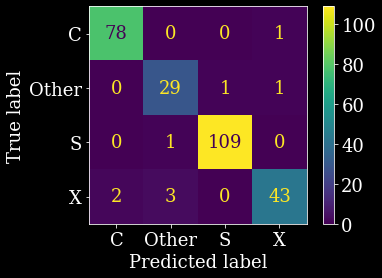

In [67]:
# For a better visualisation, let's plot the confusion matrix
import matplotlib.pyplot as plt  
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(final_clf, X_test_scaled, y_test, values_format='d')  
plt.show()  

In [68]:
# A combined score
f1_score = round(sklearn.metrics.f1_score(y_test, y_test_pred, average="weighted"), 3)
print(f"F1 Score: {f1_score}")

F1 Score: 0.966
